# 화합물 분류

- 문제 : 주어진 화합물 샘플을 활성 화합물의 확률을 예측하는 분류기 구현하기
- 접근방식 : 비정형 데이터 분석 (구조화되지 않은 텍스트로 예측)
- 제출일자 : 22년 7월 26일 - 22년 8월 2일

1. 해당 문제에서 최하단에 제시한 힌트 AUCPRC와 AUCROC 수치가 높고 치수가 2048이고 샘플수가 3977개이기에 과적합이 의심되는 상황이다.
2. 랜덤포레스트 모델의 경우 일부 파라미터 조정으로 정규화 결과가 변하지 않으므로 최소 튜닝이 가능한 일부 그래프 기반 딥러닝 모델의 경우 평가지표인 두 값이 0.93보다 높고, 로그 손실값이 0.35보다 작을 수 있다는 점을 유의할 것

### 관련 단어 정리
Compound = 화합물

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem

## EDA

### rdkit
화학물질의 정보를 담고 있는 데이터를 이용해서 화학물질의 구조식을 만들어내는 툴
- cheminfomatics toolkit

In [2]:
df = pd.read_csv('cmpd.csv')

In [3]:
df

,inchikey,smiles,group,activity
0,FNHKPVJBJVTLMP-UHFFFAOYSA-N,CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...,train,active
1,CUDVHEFYRIWYQD-UHFFFAOYSA-N,CNC(=O)c1cccc2cc(Oc3ccnc4cc(OCC5(N)CC5)c(OC)cc...,train,active
2,TTZSNFLLYPYKIL-UHFFFAOYSA-N,Cc1cc2cc(Oc3ccnc(Nc4cccc(CS(=O)(=O)NCCN(C)C)c4...,test,active
3,UOVCGJXDGOGOCZ-UHFFFAOYSA-N,COc1cc2c(cc1F)C(c1ccccc1Cl)=Nc1c(n[nH]c1C)N2,train,active
4,CUIHSIWYWATEQL-UHFFFAOYSA-N,Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...,test,active
...,...,...,...,...
5525,UBAHPEHGSJRHGA-UHFFFAOYSA-N,Cc1cccc2nc(-c3ccc(-c4cccc(CN5CCC(C(N)=O)CC5)c4...,test,inactive
5526,RTTIKBHDHKOSNI-UHFFFAOYSA-N,Cc1c2ccccc2nc2c1c1cc(NCCN(C)C)ccc1n2CCN(C)C,test,inactive
5527,HVUOSZANYULBJR-UHFFFAOYSA-N,Cc1ccc(-c2ccn(-c3ccc4c5c(n(C)c4c3)CCCNC5)c(=O)...,test,inactive
5528,SNFWCJIVWUVRNO-UHFFFAOYSA-N,N#Cc1c(-c2ccccc2C(F)(F)F)nc(SCc2ccc(OC(F)(F)F)...,test,inactive


In [4]:
# with minimal modification, we obtain the fingerprint vector using RDKit

def get_Xy(df):
    X = np.vstack(df.mol.apply(lambda m: list(AllChem.GetMorganFingerprintAsBitVect(m, 4, nBits=2048))))
    y = df.activity.eq('active').astype(float).to_numpy()
    return X, y

In [5]:
df['mol'] = df.smiles.apply(Chem.MolFromSmiles) # 데이터 프레임의 SMILES 값을 MOL형태로 바꾼 것

In [6]:
X_train, y_train = get_Xy(df[df.group.eq('train')])
X_test, y_test = get_Xy(df[df.group.eq('test')])

### 관련 사이트 정리

- [InCHI Trust](https://www.inchi-trust.org/downloads/)
- [라인 표기법](https://chem.libretexts.org/Courses/Fordham_University/Chem1102%3A_Drug_Discovery_-_From_the_Laboratory_to_the_Clinic/05%3A_Organic_Molecules/5.08%3A_Line_Notation_(SMILES_and_InChI))
- [InCHI key 정리 및 convert](http://inchi.info/inchikey_overview_en.html)
- [smiles translator](https://www2.chemie.uni-erlangen.de/services/translate/)


### 관련 단어 정리

InChIkey = (IUPAC Chemical Identifier key), InCHI의 해시 버젼
> ex) TTZSNFLLYPYKIL-UHFFFAOYSA-N	
    > 1. TTZSNFLLYPYKIL = main layer, 주층
    > 2. UHFFFAOY = stereochemistry & isotopes, 입체화학 및 동위원소
    > 3. SA = Version, 버젼
    > 4. N = Protons, 양자


SMILES = (Simplified Molecular-Input Line-Entry System), ASCII 문자열을 사용한 화확 구조 설명 줄 표기법
> ex) C1CCCCC1  =	Cyclohexane (C6H12)

group = 학습 데이터, 테스트 데이터

activity = 활성상태

In [7]:
X_train.shape, X_test.shape

((3977, 2048), (1553, 2048))

In [8]:
y_train.shape, y_test.shape

((3977,), (1553,))

In [9]:
# smiles 코드를 읽어서 분자 구조를 그리기
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolsToImage
from rdkit.Chem.Draw import MolToFile

In [10]:
mol = Chem.MolFromSmiles(df['smiles'][0])

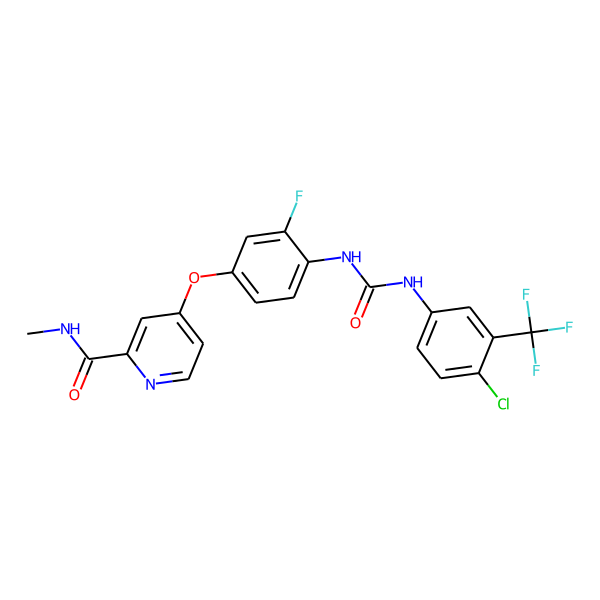

In [11]:
MolsToImage(mols=[mol], subImgSize=(600, 600))

In [12]:
df['activity'].value_counts()

active          2704
inactive        1886
unknown          599
intermediate     341
Name: activity, dtype: int64

In [13]:
df['smiles'].value_counts()

CNC(=O)c1cccc2cc(Oc3ccnc4cc(OCC5(N)CC5)c(OC)cc34)ccc12                          3
COc1cc2nccc(Oc3ccc(NC(=O)NC4CC4)c(Cl)c3)c2cc1C(N)=O                             3
CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)c3)c(F)c2)ccn1                    2
Cc1cc2c(F)c(Oc3ncnn4cc(OC[C@@H](C)O)c(C)c34)ccc2[nH]1                           2
CN1CCN(CC1)Cc2ccc(NC(=O)c3ccc(C)c(c3)C#Cc4cnc5cccnn45)cc2C(F)(F)F               2
                                                                               ..
Nc1ncc(-c2cccc(S(N)(=O)=O)c2)c2scc(-c3ccc(F)c(Cl)c3)c12                         1
COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OCCCN1CCOCC1                                    1
Cc1cc(C(=O)Nc2cc(Oc3ccc4nc(NC(=O)C5CC5)nn4c3)ccc2F)n(C)n1                       1
CNC(=O)CN1CCC(Oc2cc3c(Nc4cccc(Cl)c4F)ncnc3cc2OC)CC1                             1
CCOP(=O)(OCC)[C@@H]1C[C@H](C(=O)Nc2cc3c4c(cccc4c2)C(=O)N(CCN2CCCC2)C3=O)ON1C    1
Name: smiles, Length: 5507, dtype: int64

In [14]:
df['activity'].value_counts()

active          2704
inactive        1886
unknown          599
intermediate     341
Name: activity, dtype: int64

In [15]:
unknown_df = df[df['activity'] == 'unknown']

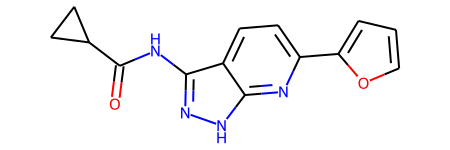

In [16]:
unknown_df['mol'][71]

## MODEL

In [17]:
from sklearn.tree import DecisionTreeClassifier

In [18]:
tree = DecisionTreeClassifier(random_state=123)

In [19]:
tree.fit(X_train, y_train)
print("test set accuracy: {:.3f}".format(tree.score(X_test, y_test)))

test set accuracy: 0.747


In [20]:
import io
import pydot
from IPython.core.display import Image
from sklearn.tree import export_graphviz
import graphviz

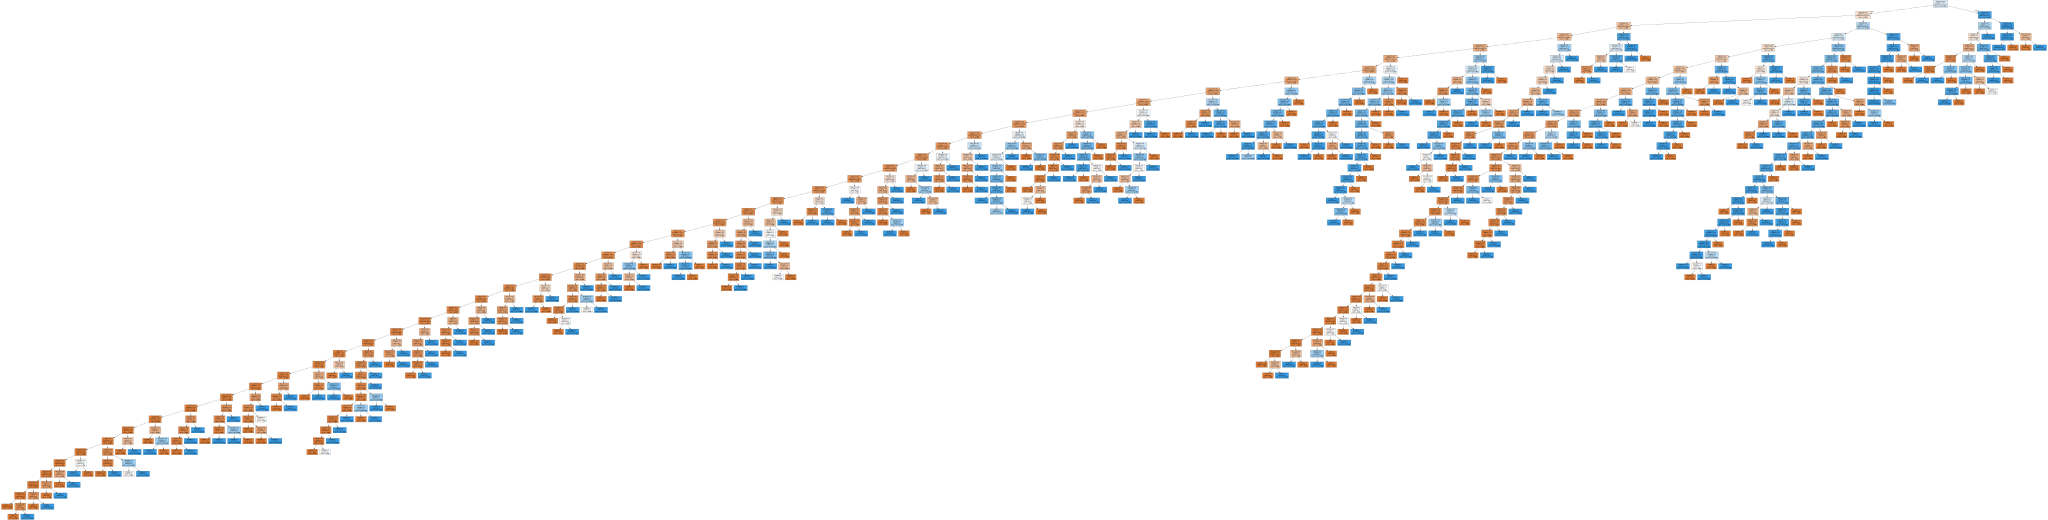

In [21]:
export_graphviz(tree, out_file= 'compound.dot' , class_names=['activity', 'nonactivity'], feature_names= None , impurity=False, filled=True)
with open('compound.dot') as f:  tree_graph = f.read()
display(graphviz.Source(tree_graph))

# re-EDA

In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mpld3
from rdkit import Chem
from rdkit.Chem import RDConfig
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import DataStructs
from sklearn.decomposition import PCA
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from mpld3 import plugins

In [28]:
def fp2arr(fp):
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp,arr)
    return arr


In [29]:
def moltosvg(mol,molSize=(225,75),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg.replace('svg:','')

In [30]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(2)
mols = df['mol']
for m in mols:
    AllChem.Compute2DCoords(m)
fps = [fpgen.GetFingerprint(m) for m in mols]
X = np.asarray([fp2arr(fp) for fp in fps])
X.shape

(5530, 2048)

In [31]:
pca = PCA(n_components=3)
res = pca.fit_transform(X)

In [33]:
svgs = [moltosvg(m) for m in mols]

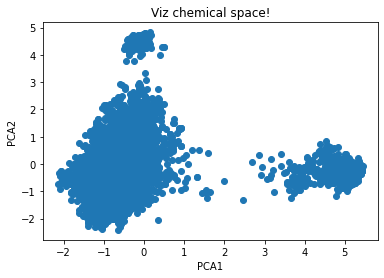

In [35]:
fig, ax = plt.subplots()
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_title('Viz chemical space!')
points = ax.scatter(res[:,0], res[:,1])
tooltip = plugins.PointHTMLTooltip(points, svgs)
plugins.connect(fig, tooltip)